<a href="https://colab.research.google.com/github/NTOU-Arrays-Start-at-One/Perspective-control-and-Color-testing/blob/main/%E8%89%B2%E6%9D%BF%E6%A0%A1%E6%AD%A3%E8%88%87%E5%88%86%E6%9E%90_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:blue">**色板分析**</span>
## <span style="color:blue">**目標：**</span>
*   ###  **分析色板上的色塊**
-----






## <span style="color:blue">**實驗步驟：**</span>
###  **1. 邊緣檢測**
###  **2. 透視校正**
###  **3. 找出色板的邊緣後，以透視校正將色板的重點資料輸出。**
###  **4. 分析色板中的色塊**

### **色板分析**

#### **函式庫**

In [314]:
from skimage import io
from skimage import transform
from sklearn.preprocessing import MinMaxScaler # 正規化
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # 表格顏色
from google.colab.patches import cv2_imshow # 為了適用於google colab的環境中

# 色差公式
!pip install --upgrade colormath
from colormath.color_conversions import convert_color
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_diff import delta_e_cie1976, delta_e_cie2000
# ssim 相似比較
from skimage.metrics import structural_similarity as ssim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### **邊緣檢測**

In [315]:
def find_corners3(im):
    # cv2_imshow(im)

    # 圖片轉為灰階
    img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # cv2_imshow(img_gray)

    # 高斯濾波
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # 將圖片進行邊緣檢測
    edges = cv2.Canny(blurred, 110, 250)

    # 尋找輪廓
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 遍歷所有輪廓
    rect_points = []  # 紀錄矩形的頂點
    for contour in contours:
        # 將輪廓近似成矩形
        approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)

        # 如果矩形的頂點數為4，就畫出矩形
        if len(approx) == 4:
            cv2.drawContours(im, [approx], 0, (0, 255, 0), 2)
            point = []
            for point in approx:
                rect_points.append((point[0][0], point[0][1]))
                cv2.circle(im, (point[0][0], point[0][1]), 5, (0, 0, 255), -1)

    # 顯示結果
    cv2_imshow(im)

    return rect_points


#### **透視校正**

##### 透視校正

In [316]:
def unwarp(img, src, dst, testing):
    h, w = img.shape[:2]
    dstW, dstH = map(int, dst[3])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (dstW, dstH), flags=cv2.INTER_LINEAR)

    if testing:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.subplots_adjust(hspace=.2, wspace=.05)
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
        y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
        ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
        ax1.set_ylim([h, 0])
        ax1.set_xlim([0, w])
        ax1.set_title('Original Image', fontsize=15)
        #ax2.imshow(cv2.flip(warped, 1)) #1:水平翻轉 0:垂直翻轉 -1:水平垂直翻轉
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Distortion Correction Result', fontsize=15)
        plt.show()
        return warped
    else:
        return warped, M

##### 設定參數後透視校正，並回傳結果

In [317]:
def regulate(im, rect_point):
  #圖片大小
  w, h = im.shape[0], im.shape[1]
  
  # 頂點(idx由色板右上開始逆時鐘編號)
  idx = 0
  for i in range(0,len(rect_point)): 
    if(i==4): print()
    print(rect_point[i], end='')
  
  # 座標(左上，右上，左下，右下)
  src = np.float32([(rect_point[1]),
          (rect_point[0]),
          (rect_point[2]),
          (rect_point[3])])

  dst = np.float32([(0, 0),
          (700, 0),
          (0, 700),
          (700, 700)])

  #校正與輸出
  return unwarp(im, src, dst, True)

##### 抓特徵矩形用以旋轉色塊至標準狀態

In [318]:
def rotate(colorBoard): # 找尋色板內的矩形，用以判斷目前的旋轉角度
  
  mark = find_mark(colorBoard)
  if mark == (0,0):
    angle = 90
  elif mark == (0,1):
    angle = 180
  elif mark == (1,1):
    angle = 270
  else: angle = 0;

  (h, w, d) = colorBoard.shape
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  colorBoard = cv2.warpAffine(colorBoard, M, (w, h))
  return colorBoard

#### **色塊顏色分析**

In [319]:
def draw_rect(img):
  im = img.copy()
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  
  # 繪製水平線
  for i in range(0, im.shape[0], 100):
    cv2.line(im, (0, i), (im.shape[1], i), (0, 0, 255), 2)

  # 繪製垂直線
  for j in range(0, im.shape[1], 100):
    cv2.line(im, (j, 0), (j, im.shape[0]), (0, 0, 255), 2)
  
  ax1.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  ax1.set_title('Grid')
  
  # 繪製矩形
  for i in range(0, im.shape[0], 100):
    for j in range(0, im.shape[1], 100):
      # 矩形的左上角座標
      x1 = j + 10
      y1 = i + 10
      # 矩形的右下角座標
      x2 = j + 90
      y2 = i + 90
      # 畫矩形
      cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2)
  ax2.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  ax2.set_title('Block')

  # 顯示圖像
  plt.show()

In [320]:
def color_analysis(im):
  colorBlockImage = []
  for i in range(0, im.shape[0]-2): # -2是為了扣掉邊框
    row = []
    for j in range(0, im.shape[1]-2):
      # 定義擷取區域的左上角和右下角座標
      x1, y1 = 110 + j*100, 110 + i*100 # 色塊向內縮10pixel
      x2, y2 = 190 + j*100, 190 + i*100
      row.append(im[y1:y2+1, x1:x2+1])
    colorBlockImage.append(row)
  
  colorBlockVal = []
  for i in range(0, 5):
    row = []
    for j in range(0, 5):
      # 使用高斯濾波器，去除躁點
      blurred = cv2.GaussianBlur(colorBlockImage[i][j], (5, 5), 0)

      # 計算均值
      val_mean = cv2.mean(blurred)
      row.append(val_mean)

    colorBlockVal.append(row)
  return colorBlockVal

In [321]:
def find_mark(img): # 利用標準差尋找旋轉用的標記
  im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  colorBlockImage = []
  for i in range(0, 2):
    row = []
    for j in range(0, 2):
      # 定義擷取區域的左上角和右下角座標
      x1, y1 = 110 + j*400, 110 + i*400 # 色塊向內縮20pixel
      x2, y2 = 190 + j*400, 190 + i*400
      row.append(im[y1:y2+1, x1:x2+1])
    colorBlockImage.append(row)
  
  colorBlockStd = []
  for i in range(0, 2):
    row = []
    for j in range(0, 2):
      # 計算標準差
      val_std = np.std(colorBlockImage[i][j])
      colorBlockStd.append({"idx": (i, j), "val_std": val_std})

  print(colorBlockStd)
  # 找出標準差最大(均勻度最小)的那一個
  max_std = max(colorBlockStd, key=lambda x: x["val_std"])
  print(max_std["idx"])
  return max_std["idx"] 

#### **色塊差異比對**


##### 色差比對(delta_e_2000)

In [322]:
def get_delta_e(color1, color2):
  # 色彩空間轉換(RGB to LAB)  
  def rgb2lab(rgb):
      return convert_color(sRGBColor(rgb[0], rgb[1], rgb[2]), LabColor)

  # 計算CIE1976和CIEDE2000的色差
  delta_e_1976 = delta_e_cie1976(rgb2lab(color1), rgb2lab(color2))
  delta_e_2000 = delta_e_cie2000(rgb2lab(color1), rgb2lab(color2))

  #print(f"CIE 1976色差：{delta_e_1976:.2f}")
  #print(f"CIEDE 2000色差：{delta_e_2000:.2f}")
  return delta_e_2000

##### 相似比對(ssim, structural similarity index)

In [323]:
def get_ssim_score(im1, im2):
  gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

  # 計算兩個灰度圖像之間的SSIM
  score, diff = ssim(gray1, gray2, full=True)
  return score

#### **分析色塊實驗**

In [324]:
def correction_and_solve(colorBoard):
  colorBoard_copy = colorBoard.copy() # 複製副本以避免畫圖影響結果
  rect_point = find_corners3(colorBoard) # 找尋邊緣，並回傳矩形的頂點座標
  dc_img = regulate(colorBoard_copy, rect_point) # 對矩形的頂點座標做透視校正
  dc_img = rotate(dc_img) # 旋轉
  plt.imshow(cv2.cvtColor(dc_img, cv2.COLOR_BGR2RGB))
  colorBlockVal = color_analysis(dc_img) # 處理並輸出色塊的代表顏色，colorBlockVal[i][j]為色塊顏色
  #draw_rect(dc_img) # 畫出色塊

  # 代表顏色的表格輸出
  fig, ax = plt.subplots()
  ax.axis('off')
  # 設置單元格文本和顏色
  cell_text = []
  for i in range(5):
      row_text = []
      row_colors = []
      for j in range(5):
          # 將RGB顏色塊和像素值一起顯示
          cell_val = f"({i},{j})\n\n{colorBlockVal[i][j][0]:.1f}\n{colorBlockVal[i][j][1]:.1f}\n{colorBlockVal[i][j][2]:.1f}"
          row_text.append(cell_val)
      cell_text.append(row_text)
  # 創建表格
  table = ax.table(cellText=cell_text, cellLoc='center', bbox=[0,0,1,1])
  # 設置表格標題
  ax.set_title('colorBlockVal')
  # 設置表格大小和字體大小
  table.auto_set_font_size(False)
  table.set_fontsize(14)
  table.scale(1, 2)
  # 設置圖形大小
  fig.set_figwidth(8)
  fig.set_figheight(8)
  plt.show()

  return colorBlockVal, dc_img

##### 透視校正與色塊影像處理

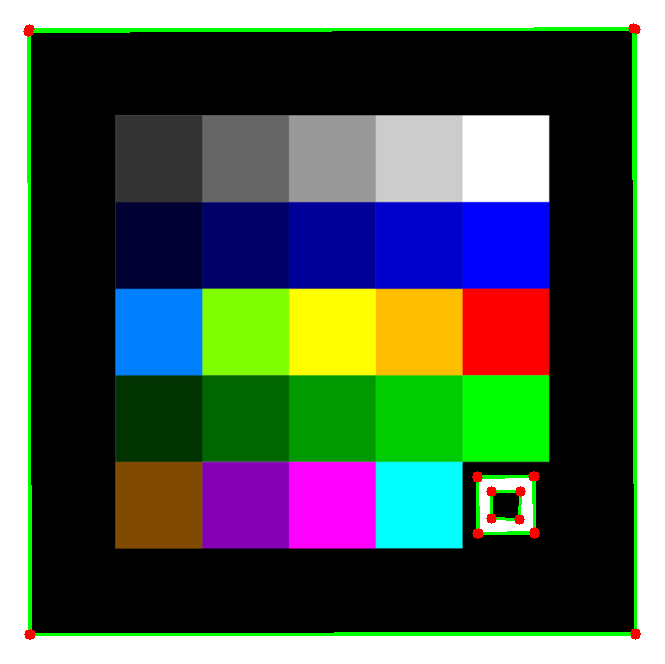

(29, 29)(29, 634)(635, 634)(635, 29)
(28, 31)(633, 28)(635, 633)(30, 634)(477, 476)(477, 533)(534, 533)(534, 476)(477, 477)(533, 476)(534, 532)(478, 533)(491, 491)(491, 518)(519, 519)(520, 491)

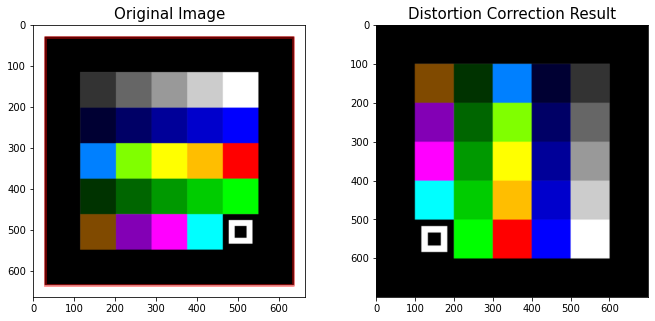

[{'idx': (0, 0), 'val_std': 0.0}, {'idx': (0, 1), 'val_std': 0.0}, {'idx': (1, 0), 'val_std': 121.98689871701633}, {'idx': (1, 1), 'val_std': 0.0}]
(1, 0)


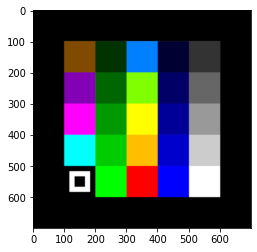

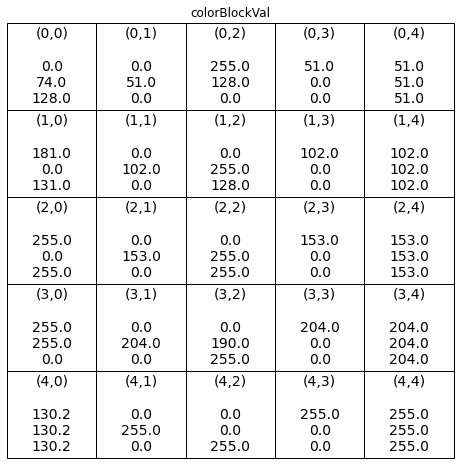

In [325]:
standard_val, standard_unwarp = correction_and_solve(cv2.imread("Standard.png"))

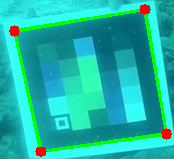

(145, 9)(14, 30)(40, 151)(166, 134)
(144, 9)(166, 133)(41, 151)(14, 31)

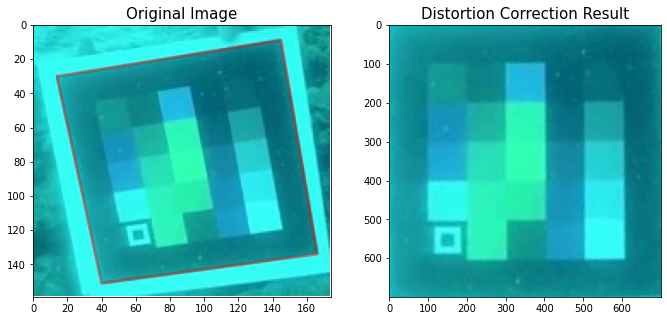

[{'idx': (0, 0), 'val_std': 2.638016346352936}, {'idx': (0, 1), 'val_std': 2.496568225419362}, {'idx': (1, 0), 'val_std': 25.17606937003977}, {'idx': (1, 1), 'val_std': 1.0037408031734194}]
(1, 0)


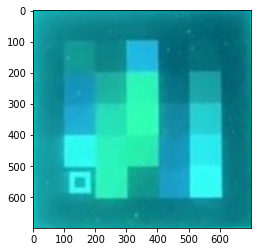

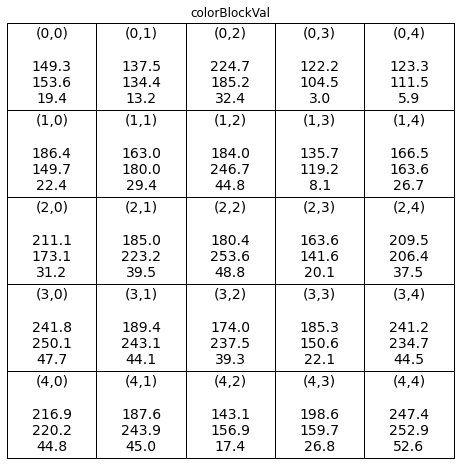

In [326]:
original_photo_val, original_photo_unwarp = correction_and_solve(cv2.imread("Original.jpg"))

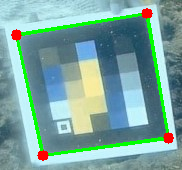

(147, 13)(16, 34)(42, 155)(168, 138)
(146, 13)(168, 137)(43, 155)(16, 35)

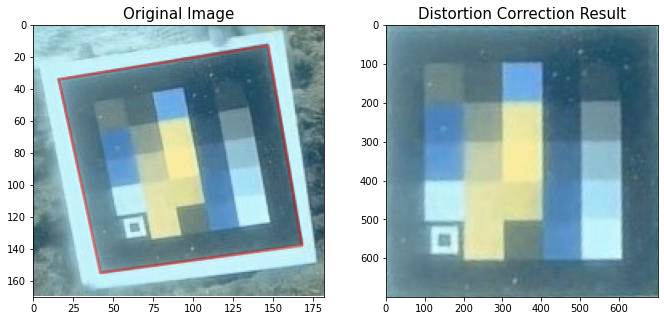

[{'idx': (0, 0), 'val_std': 3.8336036299550025}, {'idx': (0, 1), 'val_std': 4.030688197149996}, {'idx': (1, 0), 'val_std': 31.921547892447922}, {'idx': (1, 1), 'val_std': 1.6474258895176286}]
(1, 0)


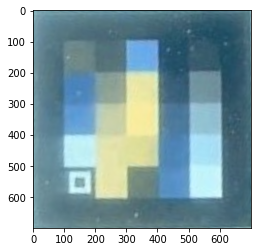

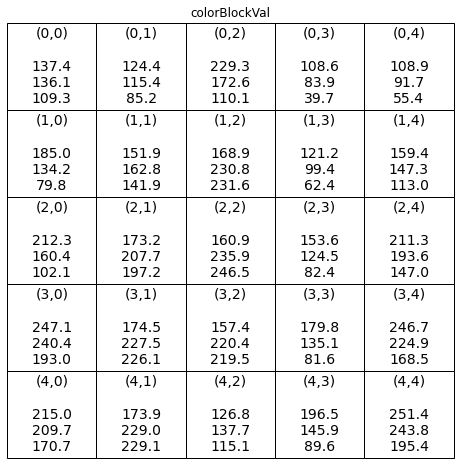

In [327]:
original_val, original_unwarp = correction_and_solve(cv2.imread("Result_Original.jpg"))

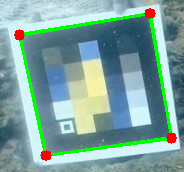

(150, 13)(19, 34)(45, 155)(171, 138)
(149, 13)(171, 137)(46, 155)(19, 35)

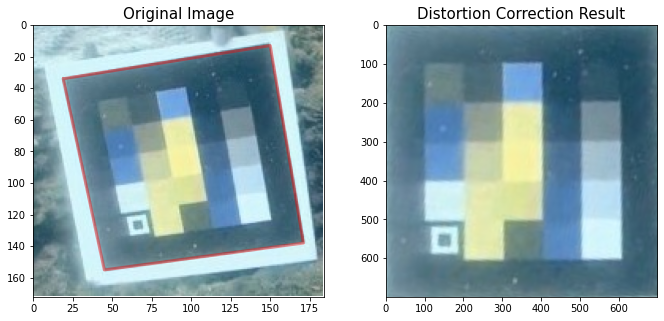

[{'idx': (0, 0), 'val_std': 3.9034697224276234}, {'idx': (0, 1), 'val_std': 3.4407878191593273}, {'idx': (1, 0), 'val_std': 33.99446486266478}, {'idx': (1, 1), 'val_std': 1.4413044941331021}]
(1, 0)


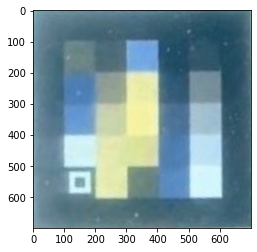

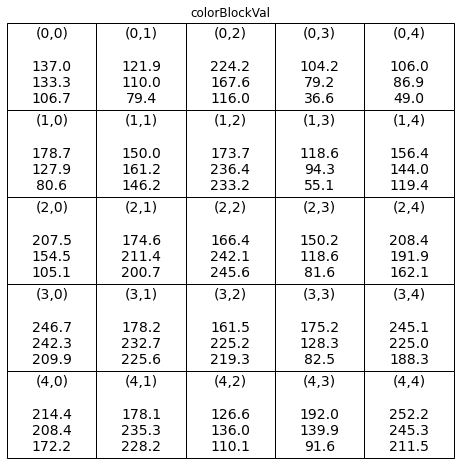

In [328]:
replicated_val, replicated_unwarp = correction_and_solve(cv2.imread("Result_Replicated.jpg"))

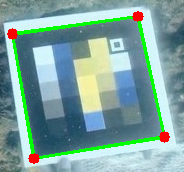

(138, 16)(12, 33)(33, 158)(164, 137)
(137, 16)(164, 136)(34, 158)(12, 34)

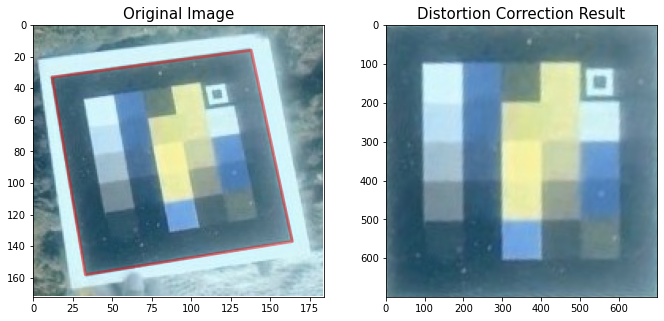

[{'idx': (0, 0), 'val_std': 1.441304494133102}, {'idx': (0, 1), 'val_std': 33.99446486266478}, {'idx': (1, 0), 'val_std': 3.4407878191593273}, {'idx': (1, 1), 'val_std': 3.9034697224276234}]
(0, 1)


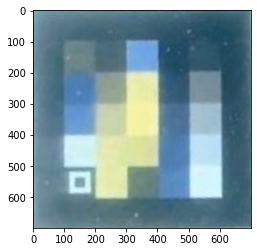

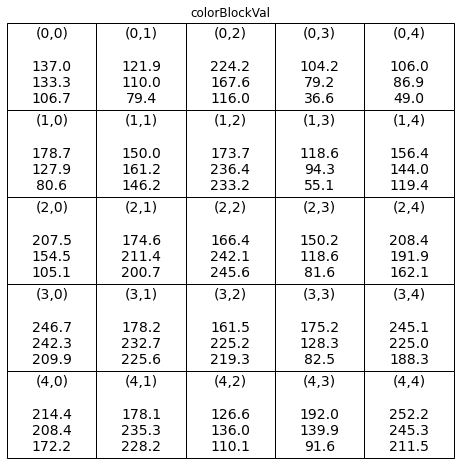

In [329]:
rotate_test_val, rotate_test_unwarp = correction_and_solve(cv2.imread("Rotate_Test.jpg"))

##### 色差比對(delta_e_2000)

Delta E 2000是用來表示兩個色彩之間的色差，值越大表示兩種色彩之間的差異越大，反之則越小。下面是一些參考值：

* 小於 1：色差幾乎不可見。
* 1 到 2：色差略微可見，但仍然相當接近。
* 2 到 10：色差明顯可見，但仍然在大多數情況下是可以接受的。
* 10 到 50：色差非常明顯，可能會被認為是不正確或不可接受的。
* 大於 50：色差非常大，幾乎肯定會被認為是不正確或不可接受的。

需要注意的是，這些參考值僅供參考，因為每個應用程序和使用者對色彩差異的容忍度都有所不同。

In [330]:
def test_and_compare(a_val, b_val):
  # 計算色差
  delta_e = []
  for i in range(0, 5):
    row = []
    for j in range(0, 5):
      row.append(get_delta_e(a_val[i][j],b_val[i][j]))
    delta_e.append(row)

  # 將 delta_e 正規化到 0~1 範圍內
  scaler = MinMaxScaler()
  delta_e_norm = scaler.fit_transform(delta_e)
  # 表格輸出
  fig, ax = plt.subplots()
  ax.axis('off')
  # 設定表格內容
  cell_text = []
  for i in range(5):
      row = []
      for j in range(5):
          row.append(f"({j},{i}),{delta_e[j][i]:.3f}")
      cell_text.append(row)
  # 繪製表格並設定顏色
  table = ax.table(cellText=cell_text, cellLoc='center', bbox=[0,0,0.8,1], cellColours=plt.cm.Greens(delta_e_norm))
  ax.set_title('Delta E')
  ax.set_aspect('equal')
  table.auto_set_font_size(False)
  table.set_fontsize(14)
  # 設定表格大小和位置
  table.scale(1, 2)
  # 設定長和寬大小
  fig.set_figwidth(10)
  fig.set_figheight(10)
  # 增加 color bar 對照
  cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
  sm = plt.cm.ScalarMappable(cmap=plt.cm.Greens, norm=plt.Normalize(vmin=0, vmax=1))
  sm.set_array([])
  fig.colorbar(sm, cax=cax)
  plt.show()

  delta_e_copy = delta_e.copy()
  return delta_e_copy

##### 色差的實驗與比較(delta_e_2000)

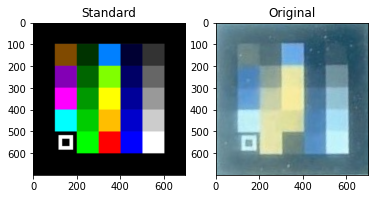

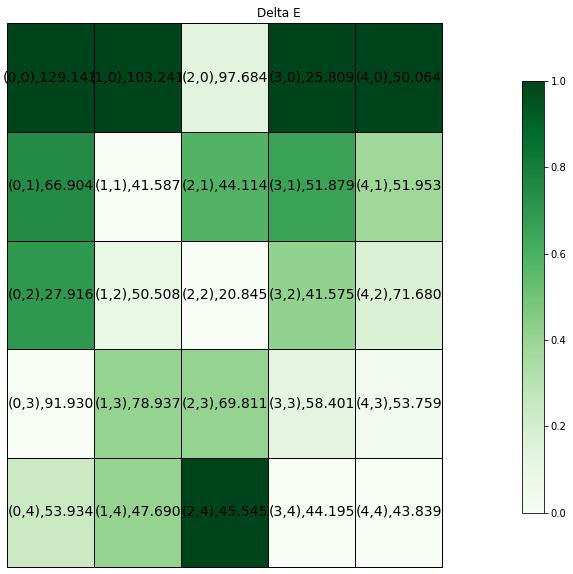

In [331]:
# 顯示
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB))
ax1.set_title('Standard')
ax2.imshow(cv2.cvtColor(original_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('Original')
plt.show()

# 測試與比較
delta_e_1 = test_and_compare(standard_val, original_val)

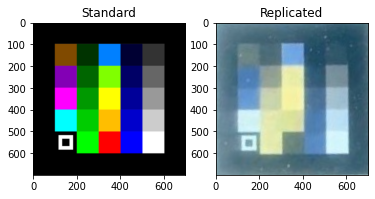

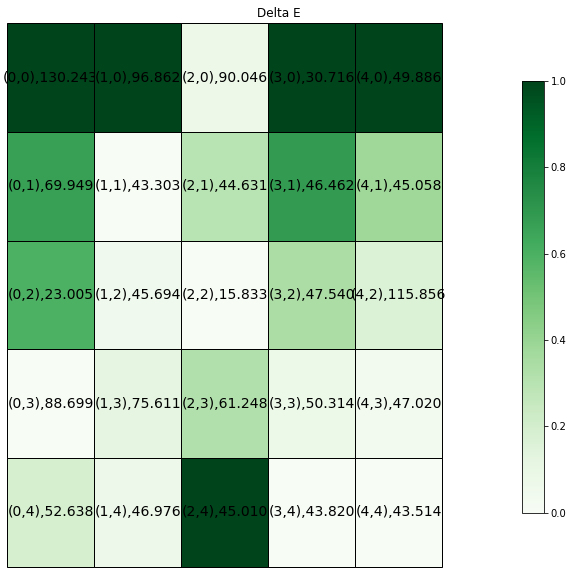

In [332]:
# 顯示
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB))
ax1.set_title('Standard')
ax2.imshow(cv2.cvtColor(replicated_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('Replicated')
plt.show()

# 測試與比較
delta_e_2 = test_and_compare(standard_val, replicated_val)

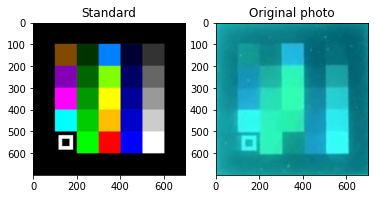

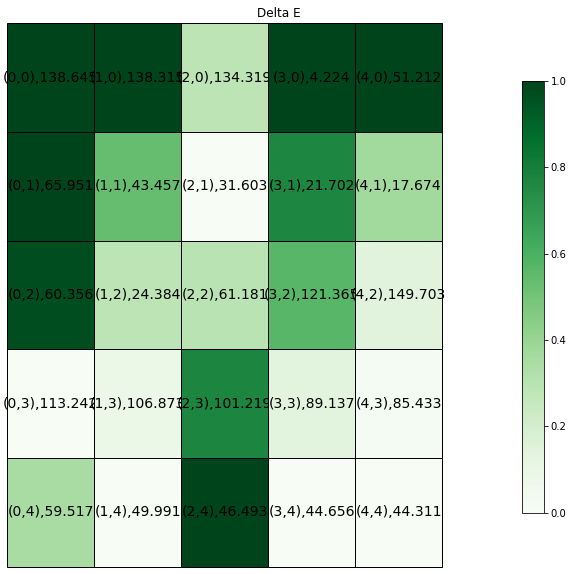

In [333]:
# 顯示
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB))
ax1.set_title('Standard')
ax2.imshow(cv2.cvtColor(original_photo_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('Original photo')
plt.show()

# 測試與比較
delta_e_3 = test_and_compare(standard_val, original_photo_val)

##### 色差比對(delta_e_2000)：兩次實驗比對

58.51765117432451
57.997337642719046


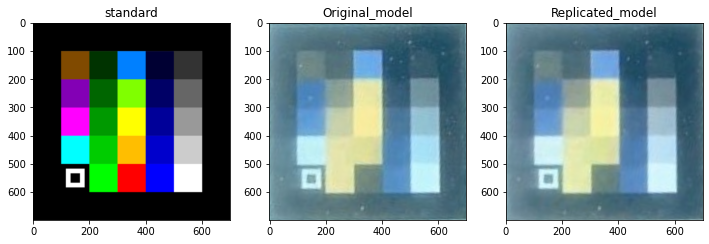

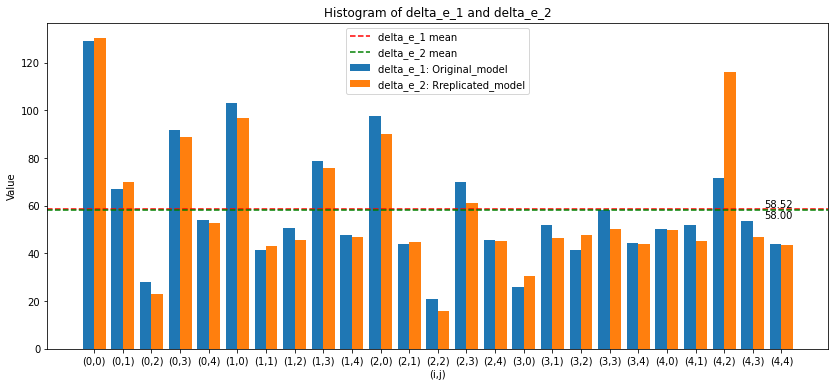

In [334]:
# 顯示
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB))
ax1.set_title('standard')
ax2.imshow(cv2.cvtColor(original_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('Original_model')
ax3.imshow(cv2.cvtColor(replicated_unwarp, cv2.COLOR_BGR2RGB))
ax3.set_title('Replicated_model')

# 計算平均值
delta_e_1 = np.array(delta_e_1)
delta_e_2 = np.array(delta_e_2)
delta_e_1_mean = np.mean(delta_e_1)
delta_e_2_mean = np.mean(delta_e_2)

# 繪製直方圖
x = np.arange(0, 25)
labels = [f"({i//5},{i%5})" for i in range(25)]
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x, delta_e_1.reshape(25), width=0.4, label='delta_e_1: Original_model')
ax.bar(x + 0.4, delta_e_2.reshape(25), width=0.4, label='delta_e_2: Rreplicated_model')

# 繪製平均值
ax.axhline(delta_e_1_mean, color='r', linestyle='--', label='delta_e_1 mean')
ax.axhline(delta_e_2_mean, color='g', linestyle='--', label='delta_e_2 mean')

ax.text(24.6, delta_e_1_mean, f"{delta_e_1_mean:.2f}", ha='right', va='bottom')
ax.text(24.6, delta_e_2_mean, f"{delta_e_2_mean:.2f}", ha='right', va='top')

# 設定圖表屬性
ax.set_xticks(x+0.4/2)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title('Histogram of delta_e_1 and delta_e_2')
ax.set_xlabel('(i,j)')
ax.set_ylabel('Value')


print(np.mean(delta_e_1))
print(np.mean(delta_e_2))

plt.show()

57.997337642719046
72.19860865972177


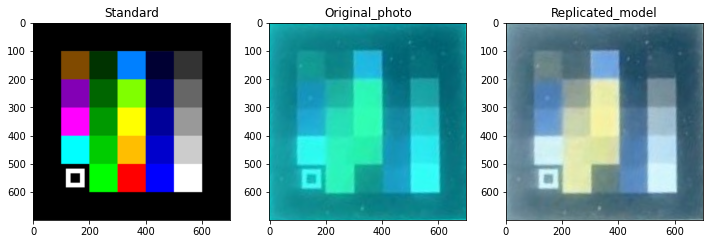

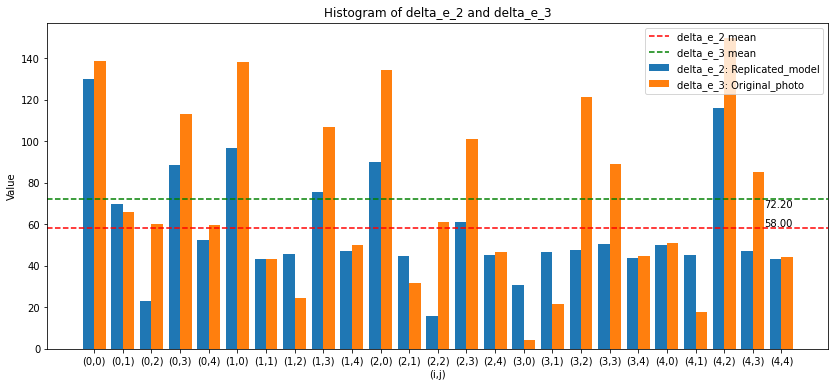

In [335]:
# 顯示
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB))
ax1.set_title('Standard')
ax2.imshow(cv2.cvtColor(original_photo_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('Original_photo')
ax3.imshow(cv2.cvtColor(replicated_unwarp, cv2.COLOR_BGR2RGB))
ax3.set_title('Replicated_model')

# 計算平均值
delta_e_2 = np.array(delta_e_2)
delta_e_3 = np.array(delta_e_3)
delta_e_2_mean = np.mean(delta_e_2) # Replicated model
delta_e_3_mean = np.mean(delta_e_3) # Original_photo

# 繪製直方圖
x = np.arange(0, 25)
labels = [f"({i//5},{i%5})" for i in range(25)]
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x, delta_e_2.reshape(25), width=0.4, label='delta_e_2: Replicated_model')
ax.bar(x + 0.4, delta_e_3.reshape(25), width=0.4, label='delta_e_3: Original_photo')

# 繪製平均值
ax.axhline(delta_e_2_mean, color='r', linestyle='--', label='delta_e_2 mean')
ax.axhline(delta_e_3_mean, color='g', linestyle='--', label='delta_e_3 mean')

ax.text(24.6, delta_e_2_mean, f"{delta_e_2_mean:.2f}", ha='right', va='bottom')
ax.text(24.6, delta_e_3_mean, f"{delta_e_3_mean:.2f}", ha='right', va='top')

# 設定圖表屬性
ax.set_xticks(x+0.4/2)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title('Histogram of delta_e_2 and delta_e_3')
ax.set_xlabel('(i,j)')
ax.set_ylabel('Value')

print(np.mean(delta_e_2))
print(np.mean(delta_e_3))

plt.show()

##### 差異圖

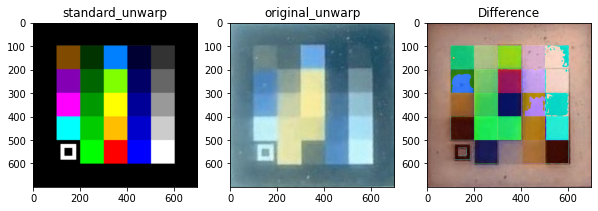

In [336]:
# 定義顏色映射
cmap = plt.cm.RdBu

img1 = cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(original_unwarp, cv2.COLOR_BGR2RGB)

# 計算兩個圖像之間的差異
diff = img1 - img2

# 繪製圖像和差異圖
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axs[0].imshow(img1, cmap=cmap)
axs[0].set_title('standard_unwarp')

axs[1].imshow(img2, cmap=cmap)
axs[1].set_title('original_unwarp')

axs[2].imshow(diff, cmap=cmap)
axs[2].set_title('Difference')

# 顯示圖像
plt.show()

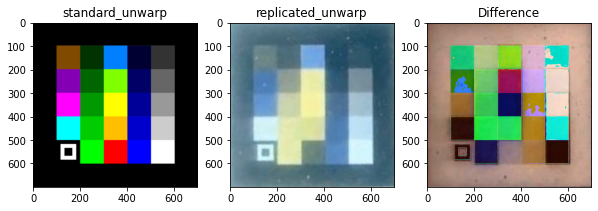

In [337]:
# 定義顏色映射
cmap = plt.cm.RdBu

img1 = cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(replicated_unwarp, cv2.COLOR_BGR2RGB)

# 計算兩個圖像之間的差異
diff = img1 - img2

# 繪製圖像和差異圖
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axs[0].imshow(img1, cmap=cmap)
axs[0].set_title('standard_unwarp')

axs[1].imshow(img2, cmap=cmap)
axs[1].set_title('replicated_unwarp')

axs[2].imshow(diff, cmap=cmap)
axs[2].set_title('Difference')

# 顯示圖像
plt.show()

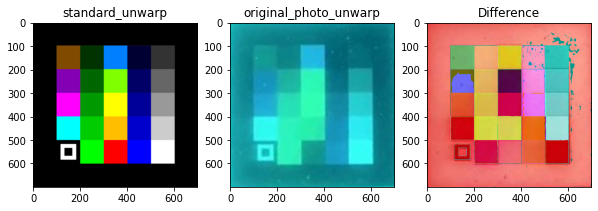

In [338]:
# 定義顏色映射
cmap = plt.cm.RdBu

img1 = cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(original_photo_unwarp, cv2.COLOR_BGR2RGB)

# 計算兩個圖像之間的差異
diff = img1 - img2

# 繪製圖像和差異圖
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axs[0].imshow(img1, cmap=cmap)
axs[0].set_title('standard_unwarp')

axs[1].imshow(img2, cmap=cmap)
axs[1].set_title('original_photo_unwarp')

axs[2].imshow(diff, cmap=cmap)
axs[2].set_title('Difference')

# 顯示圖像
plt.show()

##### 相似比對(SSIM)：original_model and replicated_model
(注意這是以校正後的整張圖做相似比對，而不是單個色塊)

SSIM（Structural Similarity Index）是一種評估影像品質的指標，它是基於影像的結構信息和感知因素，與其他傳統的影像品質評估指標（例如PSNR、MSE等）相比，更符合人眼的感知特性。

SSIM指標的值範圍從0到1，SSIM值越高代表兩張影像的結構、紋理、對比度等方面越相似，影像品質也越好。一般來說，當SSIM值大於0.9時，影像品質可以被視為非常好；當SSIM值小於0.5時，影像品質則被認為非常差。

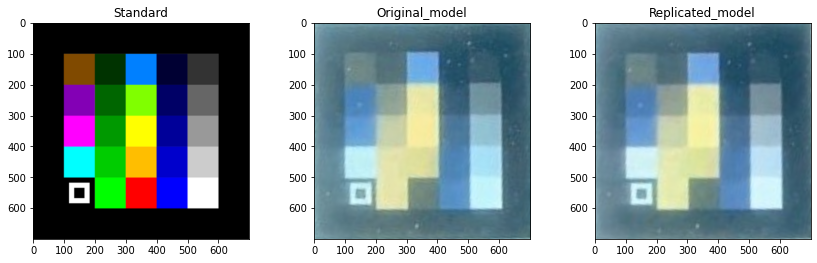

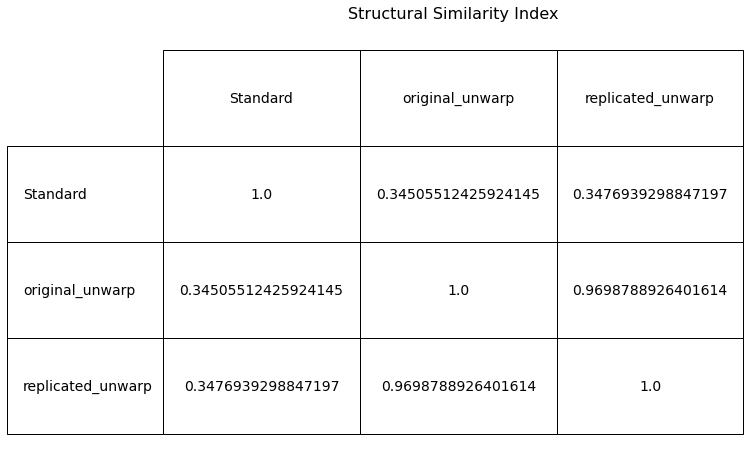

In [339]:
# 顯示
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB))
ax1.set_title('Standard')
ax2.imshow(cv2.cvtColor(original_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('Original_model')
ax3.imshow(cv2.cvtColor(replicated_unwarp, cv2.COLOR_BGR2RGB))
ax3.set_title('Replicated_model')
# 調整子圖之間的間距
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.3)

plt.show()

# 增加上下的空隙
print()

# 計算ssim
# 設定資料
stations = ['Standard', 'original_unwarp', 'replicated_unwarp']
fares = np.array([[1, get_ssim_score(standard_unwarp, original_unwarp), get_ssim_score(standard_unwarp, replicated_unwarp)],
                  [get_ssim_score(original_unwarp, standard_unwarp), 1, get_ssim_score(original_unwarp, replicated_unwarp)],
                  [get_ssim_score(replicated_unwarp, standard_unwarp), get_ssim_score(replicated_unwarp, original_unwarp), 1]])
# 畫表格
fig, ax = plt.subplots(figsize=(1, 1))
ax.axis('off')
ax.set_title('Structural Similarity Index', fontsize=16)

table = ax.table(cellText=fares, cellLoc='center', rowLabels=stations, colLabels=stations, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 1)
table.auto_set_column_width(col=list(range(len(stations))))

fig.set_figwidth(8)
fig.set_figheight(8)

plt.show()


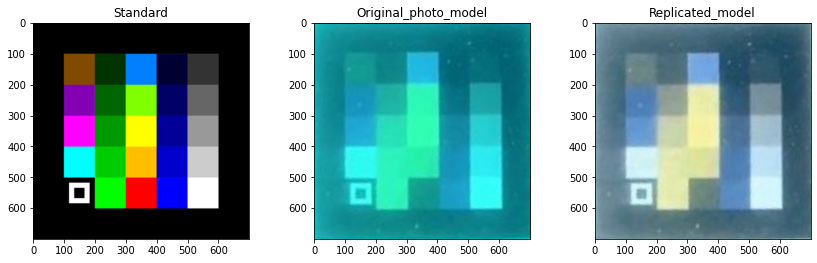

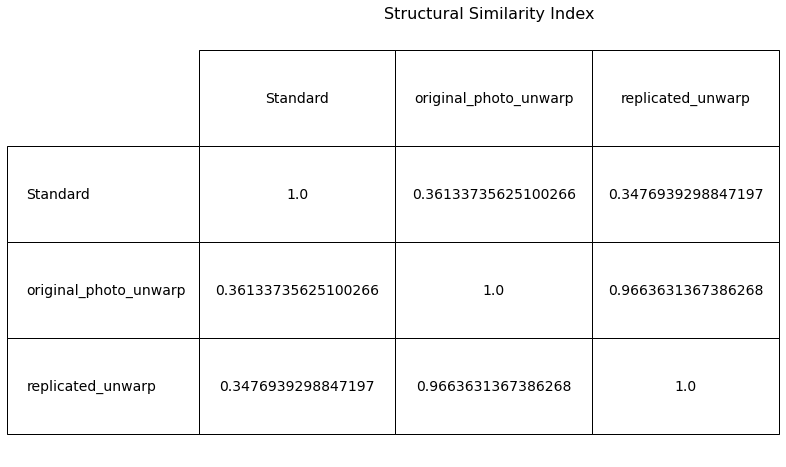

In [340]:
# 顯示
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(cv2.cvtColor(standard_unwarp, cv2.COLOR_BGR2RGB))
ax1.set_title('Standard')
ax2.imshow(cv2.cvtColor(original_photo_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('Original_photo_model')
ax3.imshow(cv2.cvtColor(replicated_unwarp, cv2.COLOR_BGR2RGB))
ax3.set_title('Replicated_model')
# 調整子圖之間的間距
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.3)

plt.show()

# 增加上下的空隙
print()

# 計算ssim
# 設定資料
stations = ['Standard', 'original_photo_unwarp', 'replicated_unwarp']
fares = np.array([[1, get_ssim_score(standard_unwarp, original_photo_unwarp), get_ssim_score(standard_unwarp, replicated_unwarp)],
                  [get_ssim_score(original_photo_unwarp, standard_unwarp), 1, get_ssim_score(original_photo_unwarp, replicated_unwarp)],
                  [get_ssim_score(replicated_unwarp, standard_unwarp), get_ssim_score(replicated_unwarp, original_photo_unwarp), 1]])
# 畫表格
fig, ax = plt.subplots(figsize=(1, 1))
ax.axis('off')
ax.set_title('Structural Similarity Index', fontsize=16)

table = ax.table(cellText=fares, cellLoc='center', rowLabels=stations, colLabels=stations, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 1)
table.auto_set_column_width(col=list(range(len(stations))))

fig.set_figwidth(8)
fig.set_figheight(8)

plt.show()
